## Implementation

In [1]:
from IOHMM import IOHMM_model
import numpy as np, pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/Financial-Data/stocks/TSLA.csv")
data.head()
data = data.dropna()

input = torch.tensor(np.array(data[['Open']]), dtype=torch.float32)
output = torch.tensor(np.array(data['Close']), dtype=torch.float32)

# Example 1

## Set up a simple model manully

In [3]:
transition_matrix = torch.tensor([[[1.,0.],[1.,0.]],[[1.,0.],[1.,0.]]])
emission_matrix = torch.tensor([[-0.1,0.1],[0.1,0.1]])

IOHMM = IOHMM_model(num_states=2, inputs=input[:100], outputs=output[:100], max_iter=1000, tol=1e-4, transition_matrix=transition_matrix, emission_matrix=emission_matrix)
print(IOHMM.initial_pi)
print(IOHMM.transition_matrix)
print(IOHMM.emission_matrix)
print(IOHMM.lsd)

Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([[[1., 0.],
         [1., 0.]],

        [[1., 0.],
         [1., 0.]]], requires_grad=True)
Parameter containing:
tensor([[-0.1000,  0.1000],
        [ 0.1000,  0.1000]], requires_grad=True)
Parameter containing:
tensor([5., 5.], requires_grad=True)


In [4]:
print(IOHMM._forward())
# torch.sum(IOHMM._forward(), dim=1)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5

In [5]:
print(IOHMM._backward())
# torch.sum(IOHMM._backward(), dim=1)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5

In [6]:
print(IOHMM._compute_gamma(IOHMM._forward(), IOHMM._backward()))
# torch.sum(IOHMM._compute_gamma(IOHMM._forward(), IOHMM._backward()), dim=1)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5

In [7]:
print(IOHMM._compute_xi(IOHMM._forward(), IOHMM._backward()))
# torch.sum(IOHMM._compute_xi(IOHMM._forward(), IOHMM._backward()), axis=1)

tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5000]],

        [[0.5000, 0.5000],
         [0.5000, 0.5

In [8]:
IOHMM._baum_welch()

Iteration 1, likelihood: -inf
Iteration 2, likelihood: -139.14013671875
Iteration 3, likelihood: -139.0100860595703
Iteration 4, likelihood: -138.90835571289062
Iteration 5, likelihood: -138.82461547851562
Iteration 6, likelihood: -138.75486755371094
Iteration 7, likelihood: -138.99172973632812
Iteration 8, likelihood: -193.3594970703125
Iteration 9, likelihood: -3018.88134765625
Iteration 10, likelihood: -599.308349609375
Iteration 11, likelihood: 0.012427536770701408
Iteration 12, likelihood: 0.05032605305314064
Iteration 13, likelihood: 0.08550626784563065
Iteration 14, likelihood: 0.11833508312702179
Iteration 15, likelihood: 0.14910945296287537
Iteration 16, likelihood: 0.17807315289974213
Iteration 17, likelihood: 0.20542870461940765
Iteration 18, likelihood: 0.2313467562198639
Iteration 19, likelihood: 0.25597143173217773
Iteration 20, likelihood: 0.2794264554977417
Iteration 21, likelihood: 0.30181869864463806
Iteration 22, likelihood: 0.3232404887676239
Iteration 23, likelihoo

KeyboardInterrupt: 

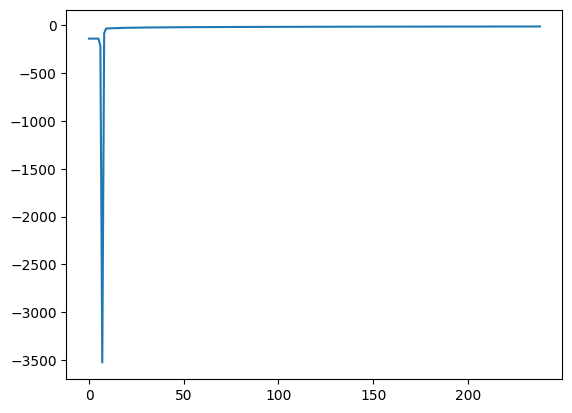

In [ ]:
plt.plot(IOHMM.history)

## See the training results

In [ ]:
print("Initial pi")
print(IOHMM.initial_pi) # to normalize
print("Transition matrix")
print(IOHMM.transition_matrix)
print("Emission matrix")
print(IOHMM.emission_matrix)
print("Sd")
print(IOHMM.lsd)

Initial pi
Parameter containing:
tensor([4.7929, 5.0561], requires_grad=True)
Transition matrix
Parameter containing:
tensor([[[-5.1586, -8.6887],
         [ 7.1586,  8.6887]],

        [[ 1.5936,  0.8244],
         [ 0.4064, -0.8244]]], requires_grad=True)
Emission matrix
Parameter containing:
tensor([[-0.1000,  0.9000],
        [ 0.1000,  0.9000]], requires_grad=True)
Sd
Parameter containing:
tensor([5., 5.], requires_grad=True)


## Viterbi

In [ ]:
#call the viterbi algorithm
IOHMM.viterbi()

TypeError: softmax() takes 2 positional arguments but 3 were given

## Predict

In [ ]:
# predict the next output given the next input
IOHMM.predict(input[11])


In [ ]:
output[11]

tensor(1.3260)